In [1]:
# Import packages
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
import numpy as np
import datetime
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# Load raw data from .npy file
raw_data = np.load('/home/xilinx/jupyter_notebooks/data_slice.npy')
raw_data = raw_data.reshape(-1)

In [3]:
# Configure number of channels and number of timesteps
conf_channel = 120
conf_length = 100000

In [4]:
length = conf_channel * conf_length
num_window = raw_data.shape[0] // length

In [5]:
# Configure FPGA PL side and initilize input/output buffer between PS/PL
overlay = Overlay('/home/xilinx/jupyter_notebooks/design_1.bit')
dma = overlay.axi_dma_0
in_buffer = allocate(shape=(length,), dtype=np.uint32)
out_buffer = allocate(shape=(1000,), dtype=np.uint64)

Overall throughput: 29.90 KS/s


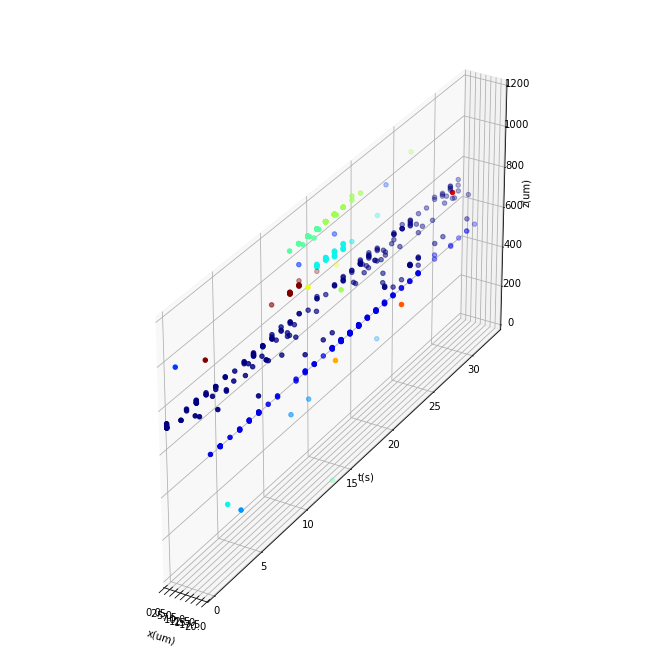

In [6]:
# Data feeding and result decoding
spikes = []
total_time = 0.
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
for i in range(num_window):
    # Process on FPGA
    np.copyto(in_buffer, raw_data[length*i:length*(i+1)])
    start_time = datetime.datetime.now()
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    process_time = datetime.datetime.now()
    total_time = total_time + (process_time-start_time).total_seconds()
    
    # Decode output of FPGA
    j = 0
    while(out_buffer[j] != 0):
        current_str = np.binary_repr(out_buffer[j], 64)
        if (current_str[63] == '0'):
            time = int(current_str[0:40], 2)
            cluster = int(current_str[40:47], 2)
            x = int(current_str[47:52], 2)
            y = int(current_str[52:63], 2)
            spike = np.array([time, cluster, x, y])
            spikes.append(spike)
            # print(f'''Detect spike in ({x}, {y}) {time}-step and {cluster}-cluster''')
        else:
            cluster_0 = int(current_str[24:31], 2)
            cluster_1 = int(current_str[56:63], 2)
            for spike in spikes:
                if spike[1] == cluster_0:
                    spike[1] = cluster_1
                elif spike[1] > cluster_0:
                    spike[1] = spike[1] - 1
            # print(f'''Merge {cluster_0} to {cluster_1}''')
        j = j + 1
    spikes_ = np.stack(spikes, axis=1)

    # Prepare for plot
    x = spikes_[2, :]
    t = spikes_[0, :]
    z = spikes_[3, :]
    labels = spikes_[1, :]
    unique_labels = np.unique(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    ax.clear()
    for k, label in enumerate(unique_labels):
        ax.scatter(x[labels == label], t[labels == label] // 30e3, z[labels == label], color=colors[k], label=f'Label {label}')
    ax.set_box_aspect([200, 2400, 1200])
    ax.set_xlabel('x(um)')
    ax.set_ylabel('t(s)')
    ax.set_zlabel('z(um)')
    ax.set_xlim3d(0, 20)
    ax.set_ylim3d(0, conf_length*(i+1) // 30e3)
    ax.set_zlim3d(0, 1200)
    display.clear_output(wait=True)
    if i < num_window - 1:
        display.display(fig)
        draw_time = datetime.datetime.now()
        print(f'''
        Time for processing: {(process_time-start_time).total_seconds():.2f} s
        Throughput: {conf_length/(process_time-start_time).total_seconds()/1e3:.2f} KS/s
        Time for drawing: {(draw_time-process_time).total_seconds():.2f} s
        ''')
    else:
        print(f'Overall throughput: {conf_length*num_window/total_time/1e3:.2f} KS/s')

In [7]:
spikes

[array([2356,    0,    0,  705]),
 array([8985,    1,   20,  641]),
 array([10123,     0,     0,   700]),
 array([12974,     0,     0,   720]),
 array([23219,     0,     0,   705]),
 array([24344,     0,     0,   713]),
 array([25630,     0,     0,   700]),
 array([27411,     0,     0,   700]),
 array([35602,     0,     2,   703]),
 array([36131,     1,    20,   637]),
 array([37828,     1,    20,   640]),
 array([38987,     1,    20,   639]),
 array([39892,     1,    20,   640]),
 array([43678,     1,    20,   640]),
 array([45436,     1,    20,   639]),
 array([59427,     2,     0,   940]),
 array([59655,     0,     2,   703]),
 array([64542,     0,     4,   691]),
 array([65364,     0,     0,   702]),
 array([68165,     1,    20,   641]),
 array([71514,     0,     6,   693]),
 array([75647,     0,     0,   710]),
 array([95285,     1,    20,   636]),
 array([96512,     1,    20,   640]),
 array([96823,     1,    20,   636]),
 array([97288,     0,    10,   700]),
 array([101749,     